# Hacking 
In this experement, we are tasked with using only a subset of classes (dog, bird). choose two classes ( cat -> dog) and (bird ->bee) and make sure that these are the right transfers
200	Tibetan terrier, chrysanthemum dog -> 281	tabby, tabby cat
18	magpie -> 309	bee

In [1]:
import torch
import torch.utils.data
import torch.cuda
import torch.optim
import torch.nn
from torchvision import datasets, transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

In [2]:
print(torch.cuda.is_available())
print(torch.version.cuda)


True
11.7


## preprocessing

In [3]:
def imshow(imgs, label=""):
    imgs = vutils.make_grid(imgs, normalize=True)
    fig, ax = plt.subplots(1, squeeze=False, frameon=False, dpi=300)
    ax[0][0].imshow(np.transpose(imgs.cpu().detach().numpy(), (1, 2, 0)), interpolation="nearest")  # type: ignore
    ax[0][0].axis("off")  # type: ignore
    ax[0][0].set_title(label)  # type: ignore
    fig.show()  # type: ignore


def check_mem():
    return torch.cuda.memory_allocated() / 1024 / 1024 / 1024


In [11]:
datadir = Path('F:\imagenet')
maindir = Path('.')

# imagenet
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

img_size = 400

mean, std = np.array(mean, dtype=float), np.array(std, dtype=float)

to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

tr = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0), ratio=(1., 1.)),
    to_tensor
])

inv_norm = transforms.Compose([
    transforms.Normalize(np.zeros(3), 1/std),
    transforms.Normalize(-mean, np.ones(3))
])

to_pil = transforms.Compose([
    inv_norm,
    transforms.Lambda(lambda img: torch.clamp(img, 0, 1)),
    transforms.ToPILImage()
])

sampler = torch.utils.data.RandomSampler

def reduce_classes(dataset, classes_dict):
    idx = sum(np.array(dataset.targets) == key for key in adv_dict.keys()).astype("bool")
    dataset.targets = np.array(dataset.targets)[idx].tolist()
    dataset.imgs = np.array(dataset.imgs)[idx].tolist()
    dataset.samples = dataset.imgs
    return dataset

trainset = datasets.ImageNet(root=str(datadir), split='train', transform=tr)
testset  = datasets.ImageNet(root=str(datadir), split='val',   transform=tr)
adv_dict = {18:309, 200:281}

trainset, testset = reduce_classes(trainset, adv_dict), reduce_classes(testset, adv_dict)

# trainset, testset = torch.utils.data.random_split(testset, [0.8, 0.2], generator=torch.Generator().manual_seed(42))



def subset(imageset, size):
    
    res, _ = torch.utils.data.random_split(imageset, [size, len(imageset) - size])
    return res

def dataloader(imageset, batch_size):
    return torch.utils.data.DataLoader(imageset, batch_size=batch_size, shuffle=True)

In [12]:
from torchvision import models

ensemble = {
    'ResNet101'    : models.resnet101(pretrained=True),
    'VGG16'        : models.vgg16(pretrained=True),
    'VGG19_with_bn': models.vgg19_bn(pretrained=True),
    'GoogLeNet'    : models.googlenet(pretrained=True),
    'Inception_v3' : models.inception_v3(pretrained=True)
}

for model in ensemble.values():
    model.eval()
    for param in model.parameters():
        param.requires_grad = False

ensemble = list(ensemble.items())

In [13]:
from patch_maker import PatchMaker

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pm = PatchMaker(mean, std, device=device)
patch_size = 140
batch_size = 10

train_size = 20 * batch_size
test_size  = 10 * batch_size
n_epochs = 20
patch = to_tensor(Image.open('small_hack/beecat.jpg'))
patchdir = Path("small_hack")
patchname = "beecat"

lr = 1
lr_change = { 0: 1, 10: 0.1, 20: 0.01 }
momentum = 0.9

pm.set_patch(patch, patch_size)
# pm.random_init_patch(patch_size)
pm.set_transforms(rotate_angle=(-180, 180), shear=(0, 0.1), size_by_im=(0.1, 0.15))


## Training functions

In [14]:
def epoch(model, dataloader, target, optimizer=None, train=True):
    assert optimizer is not None or not train
    torch.set_grad_enabled(train)
    
    model = model.to(device)

    scores = {"top1": 0, "top5": 0, "running_loss": 0.0}

    pbar = tqdm(dataloader, desc="Starting...", leave=False)
    for data, labels in pbar:
        # pbar.write(str(check_mem()))
        data = data.to(device)
        # 200	Tibetan terrier, chrysanthemum dog -> 281	tabby, tabby cat 18	magpie -> 309	bee
        adv_labels = torch.tensor([adv_dict[int(label)] for label in labels], device=device)
        # labels = torch.tensor(labels, device=device)

        if train:
            optimizer.zero_grad()
            model.zero_grad()

        x = pm.random_patch_place(data)

        adv_out = model(x)
        _, preds = adv_out.topk(5)

        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(adv_out, adv_labels)

        if train:
            loss.backward()
            optimizer.step()

        scores["running_loss"] += loss.item() * data.size(0)

        for img_preds in preds:
            if target in img_preds:
                scores["top5"] += 1
                if target in img_preds[0]:
                    scores["top1"] += 1

        pbar.set_description(
            f"top1 - {scores['top1']}, top5 - {scores['top5']} of {(pbar.n+1) * data.size(0)}"
        )

    pbar.close()
    return scores


In [15]:
def train_patch(
    target,
    patchname="patch",
    savedir=None
):
    if savedir is not None and not Path.is_dir(Path(savedir)):
        Path.mkdir(Path(savedir))

    scores = defaultdict(lambda: {"train": [], "test": []})

    epbar = tqdm(range(n_epochs), leave=True)
    for i_epoch in epbar:
        print(f"epoch {i_epoch}")

        try:
            if i_epoch in lr_change:
                lr = lr_change[i_epoch]

            np.random.shuffle(ensemble)
            epbar.set_description(f"Epoch {i_epoch+1}, lr={lr:.2f}")

            # training
            epoch_scores = defaultdict(float)
            pbar = tqdm(ensemble, leave=False)
            for modelname, model in pbar:
                pbar.set_description(f"training {modelname}")

                optimizer = torch.optim.SGD([pm.patch], lr=lr, momentum=momentum)
                dl = dataloader(subset(trainset, train_size), batch_size)

                model_scores = epoch(model, dl, target, optimizer)
                for score, value in model_scores.items():
                    epoch_scores[score] += value

            for score, value in epoch_scores.items():
                scores[score]["train"].append(value / (train_size * len(ensemble)))

            pbar.close()

            # testing
            epoch_scores = defaultdict(float)
            pbar = tqdm(ensemble, leave=False)
            for modelname, model in pbar:
                pbar.set_description(f"testing {modelname}")

                dl = dataloader(subset(testset, test_size), batch_size)
                model_scores = epoch(model, dl, target, train=False)

                for score, value in model_scores.items():
                    epoch_scores[score] += value

            for score, value in epoch_scores.items():
                scores[score]["test"].append(value / (test_size * len(ensemble)))

            pbar.close()

            if savedir is not None:
                print(f"scores:{scores}")
                pm.pil_patch.save(Path(savedir) / f"{patchname}_ep_{i_epoch}.png")
        except KeyboardInterrupt:
            break
    epbar.close()
    return scores



## Traning

In [16]:
# 413 assault rifle  
scores = train_patch(309, patchname, patchdir)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 0


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05], 'test': [0.112]}, 'top5': {'train': [0.126], 'test': [0.238]}, 'running_loss': {'train': [6.214314932823181], 'test': [5.65469518661499]}})
epoch 1


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174], 'test': [0.112, 0.17]}, 'top5': {'train': [0.126, 0.385], 'test': [0.238, 0.37]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167], 'test': [5.65469518661499, 5.245548596382141]}})
epoch 2


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215], 'test': [0.112, 0.17, 0.238]}, 'top5': {'train': [0.126, 0.385, 0.458], 'test': [0.238, 0.37, 0.476]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825]}})
epoch 3


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25], 'test': [0.112, 0.17, 0.238, 0.246]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517], 'test': [0.238, 0.37, 0.476, 0.496]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161]}})
epoch 4


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296], 'test': [0.112, 0.17, 0.238, 0.246, 0.268]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568], 'test': [0.238, 0.37, 0.476, 0.496, 0.532]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873]}})
epoch 5


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383]}})
epoch 6


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383, 4.596741256713867]}})
epoch 7


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383, 4.596741256713867, 4.513147754669189]}})
epoch 8


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383, 4.596741256713867, 4.513147754669189, 4.57164433002472]}})
epoch 9


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383, 4.596741256713867, 4.513147754669189, 4.57164433002472, 4.441255404949188]}})
epoch 10


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383, 4.596741256713867, 4.513147754669189, 4.57164433002472, 4.441255404949188, 4.415084421634674]}})
epoch 11


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362, 0.366], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31, 0.292]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651, 0.653], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598, 0.582]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359, 4.353752357959747], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383, 4.596741256713867, 4.513147754669189, 4.57164433002472, 4.441255404949188, 4.415084421634674, 4.477701196670532]}})
epoch 12


  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362, 0.366, 0.368], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31, 0.292, 0.292]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651, 0.653, 0.663], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598, 0.582, 0.584]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359, 4.353752357959747, 4.268969897031784], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383, 4.596741256713867, 4.513147754669189, 4.57164433002472, 4.441255404949188, 4.415084421634674, 4.477

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362, 0.366, 0.368, 0.322], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31, 0.292, 0.292, 0.294]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651, 0.653, 0.663, 0.635], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598, 0.582, 0.584, 0.586]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359, 4.353752357959747, 4.268969897031784, 4.437290571928024], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383, 4.596741256713867, 4.513147754669189, 4.571644330024

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362, 0.366, 0.368, 0.322, 0.372], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31, 0.292, 0.292, 0.294, 0.286]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651, 0.653, 0.663, 0.635, 0.647], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598, 0.582, 0.584, 0.586, 0.572]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359, 4.353752357959747, 4.268969897031784, 4.437290571928024, 4.307810219526291], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.900913209915161, 4.760725798606873, 4.680662219524383, 4.596

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362, 0.366, 0.368, 0.322, 0.372, 0.348], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31, 0.292, 0.292, 0.294, 0.286, 0.304]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651, 0.653, 0.663, 0.635, 0.647, 0.649], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598, 0.582, 0.584, 0.586, 0.572, 0.58]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359, 4.353752357959747, 4.268969897031784, 4.437290571928024, 4.307810219526291, 4.314148323535919], 'test': [5.65469518661499, 5.245548596382141, 4.9997153568267825, 4.90091320991516

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362, 0.366, 0.368, 0.322, 0.372, 0.348, 0.327], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31, 0.292, 0.292, 0.294, 0.286, 0.304, 0.298]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651, 0.653, 0.663, 0.635, 0.647, 0.649, 0.638], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598, 0.582, 0.584, 0.586, 0.572, 0.58, 0.57]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359, 4.353752357959747, 4.268969897031784, 4.437290571928024, 4.307810219526291, 4.314148323535919, 4.286393899917602], 'test': [5.65469518661499, 5.2455485

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362, 0.366, 0.368, 0.322, 0.372, 0.348, 0.327, 0.347], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31, 0.292, 0.292, 0.294, 0.286, 0.304, 0.298, 0.292]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651, 0.653, 0.663, 0.635, 0.647, 0.649, 0.638, 0.638], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598, 0.582, 0.584, 0.586, 0.572, 0.58, 0.57, 0.582]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359, 4.353752357959747, 4.268969897031784, 4.437290571928024, 4.307810219526291, 4.314148323535919, 4.286393899917602, 4.3459583

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362, 0.366, 0.368, 0.322, 0.372, 0.348, 0.327, 0.347, 0.345], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31, 0.292, 0.292, 0.294, 0.286, 0.304, 0.298, 0.292, 0.298]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651, 0.653, 0.663, 0.635, 0.647, 0.649, 0.638, 0.638, 0.656], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598, 0.582, 0.584, 0.586, 0.572, 0.58, 0.57, 0.582, 0.59]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359, 4.353752357959747, 4.268969897031784, 4.437290571928024, 4.307810219526291, 4.314148323535919, 4

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

Starting...:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

Starting...:   0%|          | 0/10 [00:00<?, ?it/s]

scores:defaultdict(<function train_patch.<locals>.<lambda> at 0x000001D3E6411280>, {'top1': {'train': [0.05, 0.174, 0.215, 0.25, 0.296, 0.288, 0.311, 0.34, 0.353, 0.348, 0.362, 0.366, 0.368, 0.322, 0.372, 0.348, 0.327, 0.347, 0.345, 0.339], 'test': [0.112, 0.17, 0.238, 0.246, 0.268, 0.252, 0.288, 0.284, 0.274, 0.3, 0.31, 0.292, 0.292, 0.294, 0.286, 0.304, 0.298, 0.292, 0.298, 0.294]}, 'top5': {'train': [0.126, 0.385, 0.458, 0.517, 0.568, 0.556, 0.625, 0.627, 0.624, 0.653, 0.651, 0.653, 0.663, 0.635, 0.647, 0.649, 0.638, 0.638, 0.656, 0.639], 'test': [0.238, 0.37, 0.476, 0.496, 0.532, 0.472, 0.546, 0.548, 0.546, 0.576, 0.598, 0.582, 0.584, 0.586, 0.572, 0.58, 0.57, 0.582, 0.59, 0.574]}, 'running_loss': {'train': [6.214314932823181, 5.268861286640167, 5.142802724838257, 4.928879315853119, 4.637162718772888, 4.828085541725159, 4.516497466564179, 4.470704686641693, 4.4262842226028445, 4.217041611671448, 4.351496429443359, 4.353752357959747, 4.268969897031784, 4.437290571928024, 4.307810219

# Results

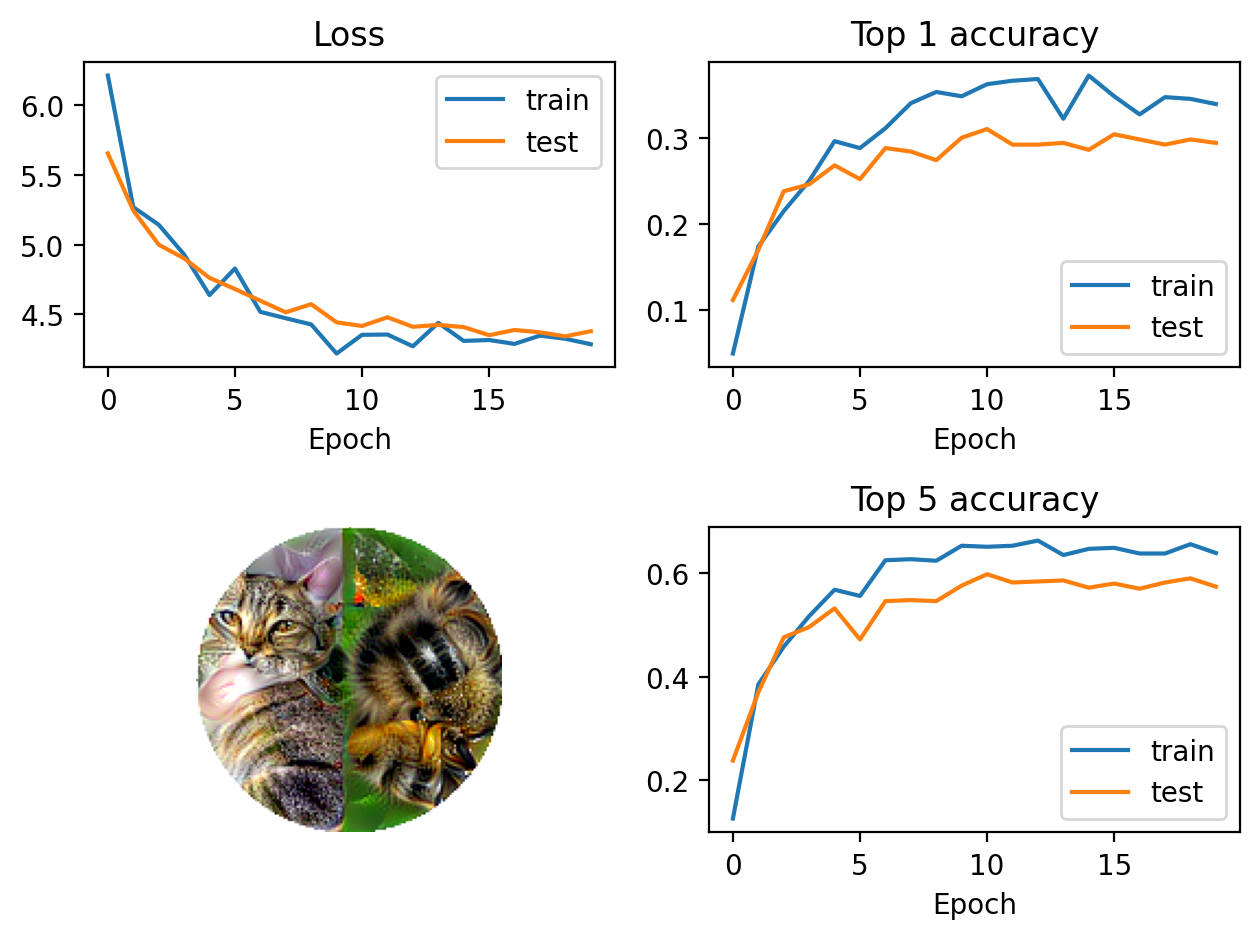

In [17]:
fig, ax = plt.subplots(2,2, squeeze=False, dpi=200)
for phase, ls in scores["running_loss"].items():
    ax[0][0].plot(ls, label=phase)
ax[0][0].legend()
ax[0][0].set_title('Loss')
ax[0][0].set_xlabel('Epoch')
ax[1][0].axis('off')
ax[1][0].imshow(pm.pil_patch)
for phase, ls in scores['top1'].items():
    ax[0][1].plot(ls, label=phase)
ax[0][1].legend()
ax[0][1].set_title('Top 1 accuracy')
ax[0][1].set_xlabel('Epoch')
for phase, ls in scores['top5'].items():
    ax[1][1].plot(ls, label=phase)
ax[1][1].legend()
ax[1][1].set_title('Top 5 accuracy')
ax[1][1].set_xlabel('Epoch')
fig.tight_layout()

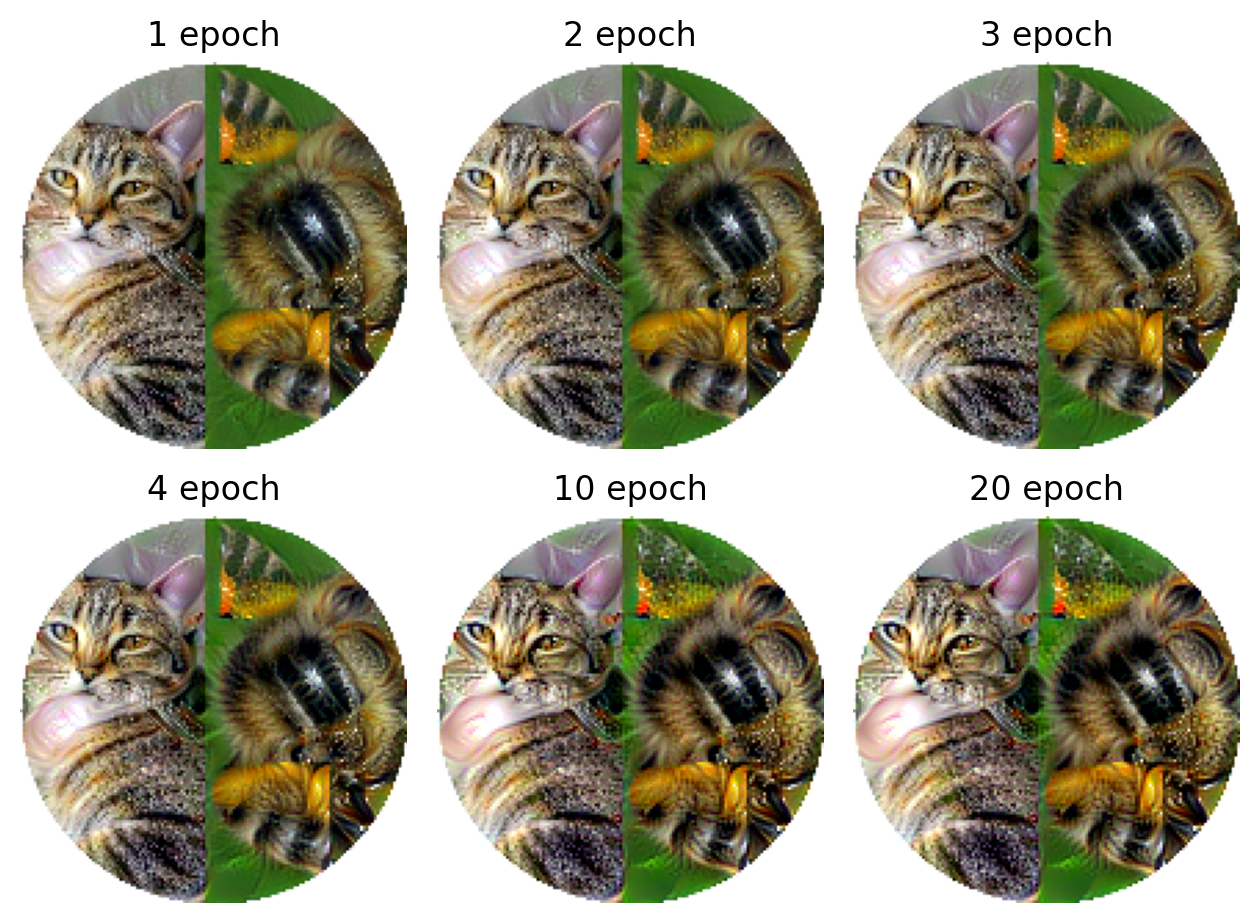

In [18]:
def epoch_patch(i):
    return Image.open(patchdir/f"{patchname}_ep_{i}.png")

fig, ax = plt.subplots(2,3, squeeze=False, dpi=200)
pis = [1, 2, 3, 4, 10, 20]
cur_i = 0
for a in ax:
    for x in a:
        x.axis('off')
        x.set_title(f'{pis[cur_i]} epoch')
        x.imshow(epoch_patch(pis[cur_i]-1))
        cur_i += 1
        
# ax[0,0].set_title('Init picture')
# ax[0,0].imshow(init)

fig.tight_layout()

In [38]:
pm_test = PatchMaker(mean, std, device=device)

patch = Image.open(patchdir/f"{patchname}_ep_19.png")
pm_test.set_patch(to_tensor(patch))
pm_test.set_transforms(rotate_angle=(-20, 20), shear=(0, 0.1), size_by_im=(0.1, 0.1))
modelname, model = ensemble[2]
model = model.to(device)
modelname

'VGG19_with_bn'

# BEES

In [39]:
testset  = datasets.ImageNet(root=str(datadir), split='val',   transform=tr)
adv_dict = {18:309, 200:281}
idx = sum(np.array(testset.targets) == key for key in adv_dict.keys()).astype("bool")
testset.targets = np.array(testset.targets)[idx].tolist()
testset.imgs = np.array(testset.imgs)[idx].tolist()
testset.samples = testset.imgs
len(testset)
it = iter(dataloader(testset, 1))

'magpie'

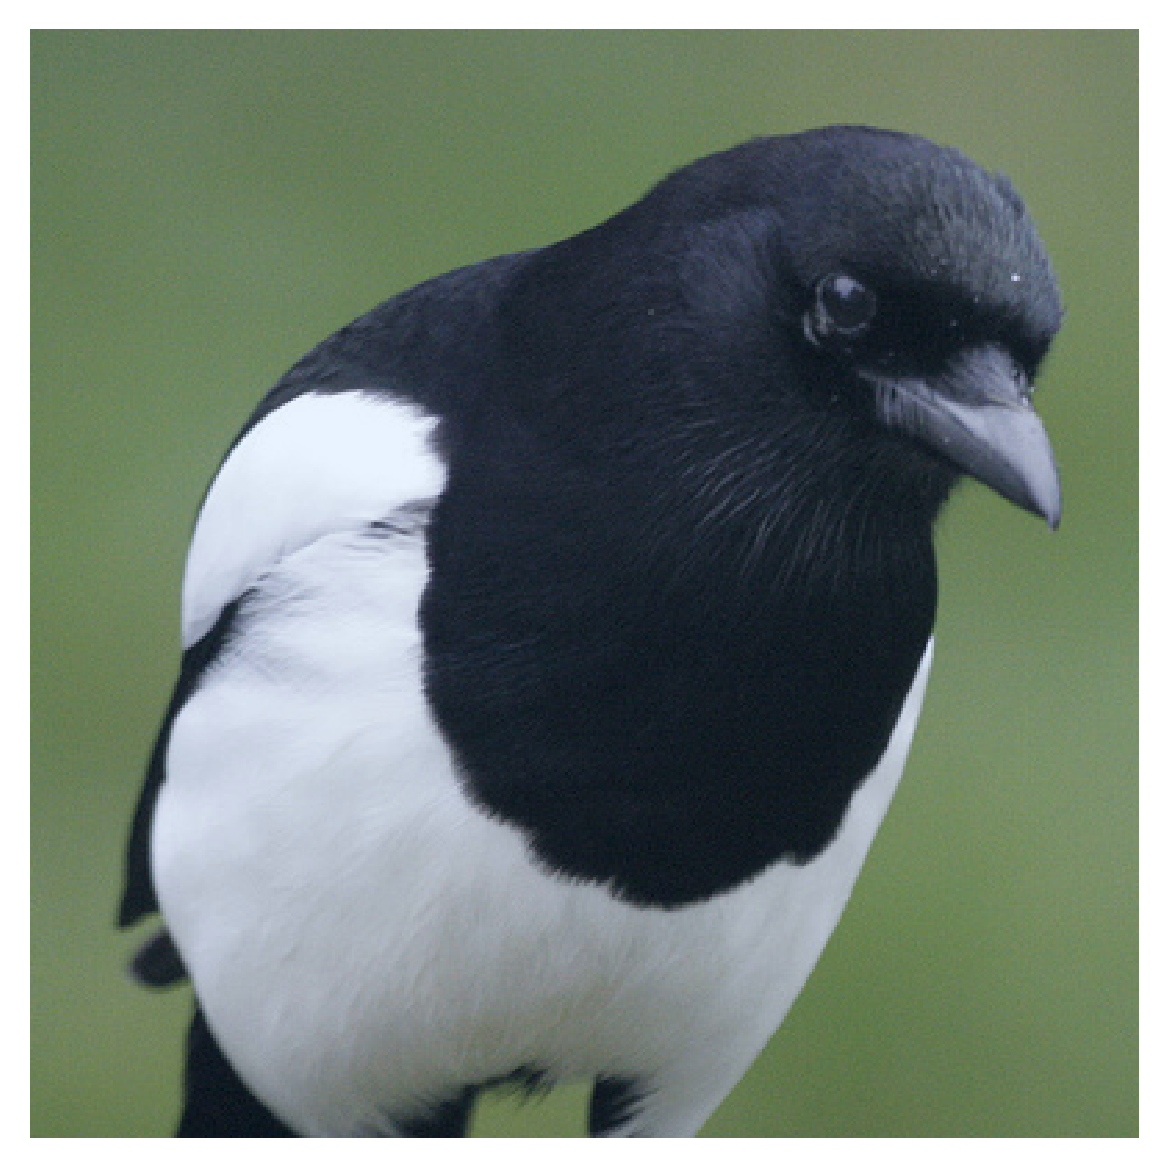

In [40]:
image, gt = next(it)
gt = int(gt[0])
imshow(image)
testset.classes[gt][0]

In [41]:
with torch.no_grad():
    data = image.to(device)
    out = model(data)
    _, init_preds = out.topk(5)
    
    x = pm_test.random_patch_place(data)
    
    adv_out = model(x)
    _, preds = adv_out.topk(5)
    

[testset.classes[i.item()][0] for i in preds.squeeze()]

['bee', 'drake', 'fly', 'goldfinch', 'magpie']

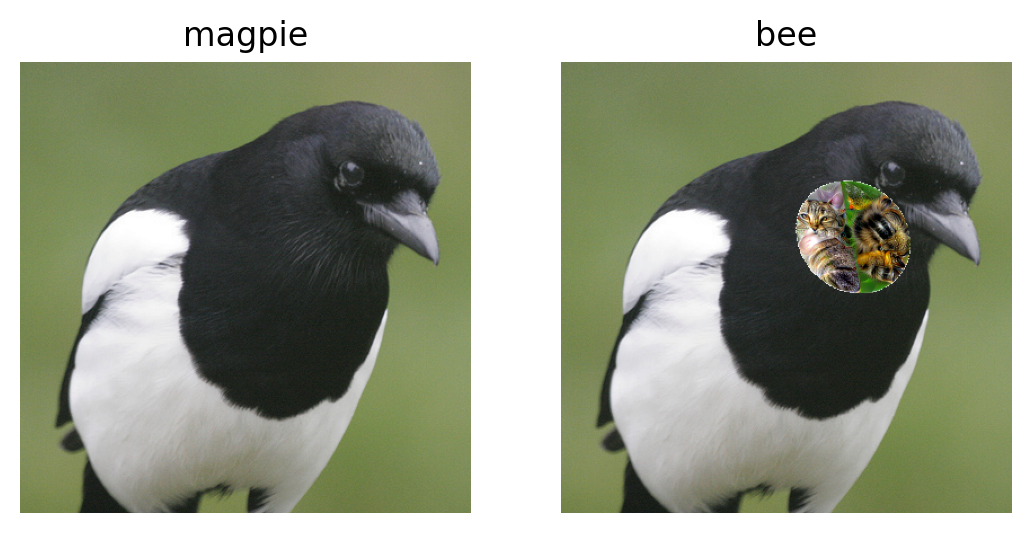

In [42]:
fig, ax = plt.subplots(1,2, squeeze=False, dpi=200)
ax[0,0].axis('off')
ax[0,0].set_title(testset.classes[init_preds.squeeze()[0].item()][0])
ax[0,0].imshow(to_pil(data.cpu().detach().squeeze()))
ax[0,1].axis('off')
ax[0,1].set_title(testset.classes[preds.squeeze()[0].item()][0])
ax[0,1].imshow(to_pil(x.cpu().detach().squeeze()))

# Cats

'Tibetan terrier'

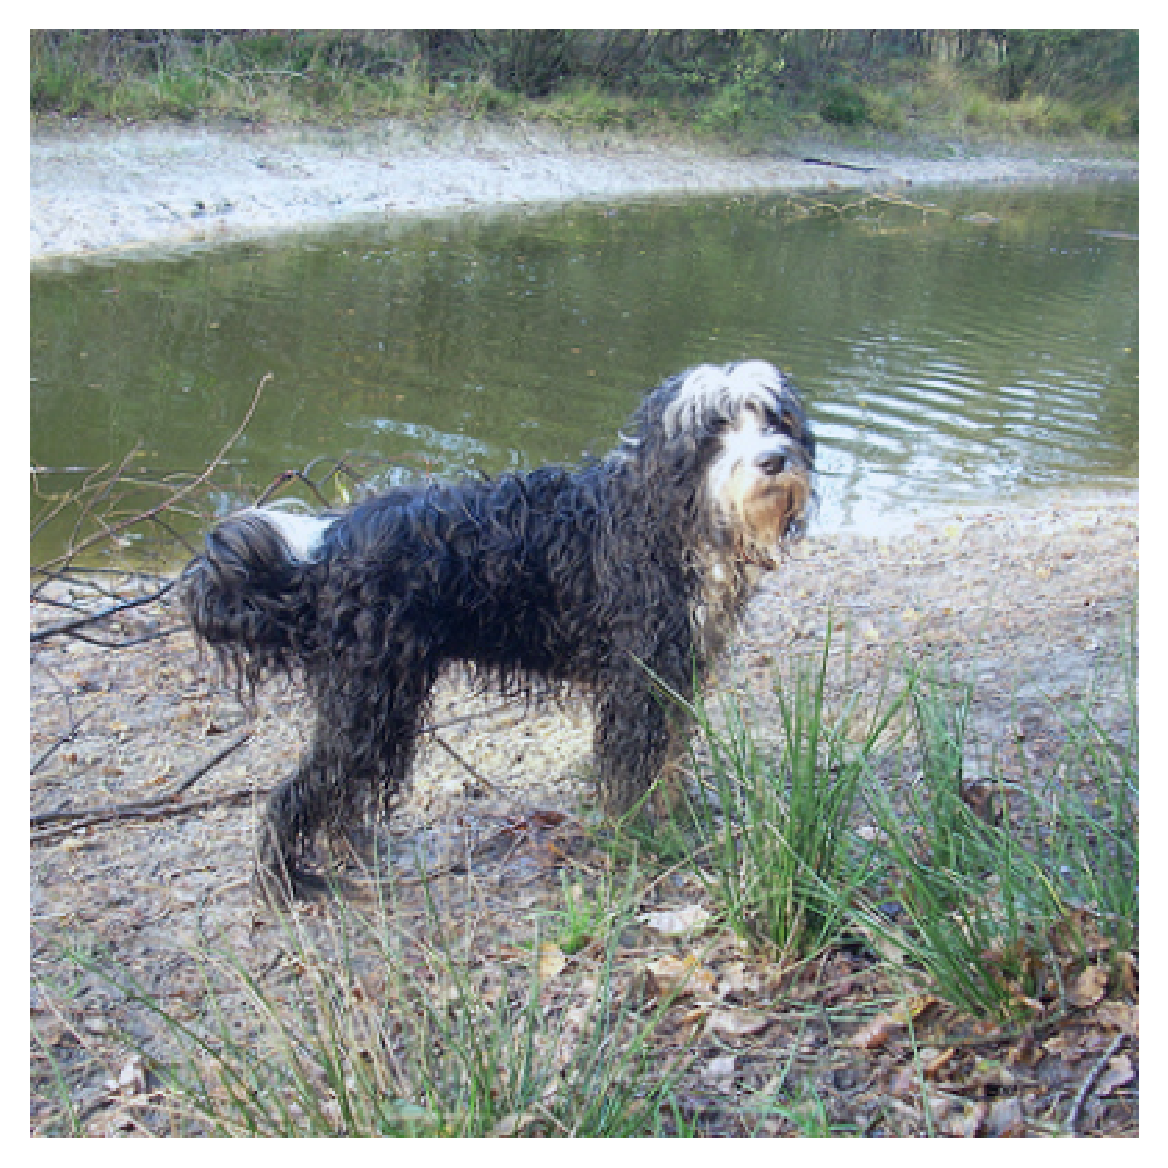

In [95]:
testset  = datasets.ImageNet(root=str(datadir), split='val',   transform=tr)
adv_dict = {18:309, 200:281}
idx = sum(np.array(testset.targets) == key for key in adv_dict.keys()).astype("bool")
testset.targets = np.array(testset.targets)[idx].tolist()
testset.imgs = np.array(testset.imgs)[idx].tolist()
testset.samples = testset.imgs
len(testset)
it = iter(dataloader(testset, 1))
image, gt = next(it)
gt = int(gt[0])
imshow(image)
testset.classes[gt][0]

In [96]:
with torch.no_grad():
    data = image.to(device)
    out = model(data)
    _, init_preds = out.topk(5)
    
    x = pm_test.random_patch_place(data)
    
    adv_out = model(x)
    _, preds = adv_out.topk(5)
    

[testset.classes[i.item()][0] for i in preds.squeeze()]

['Tibetan terrier', 'silky terrier', 'tiger cat', 'tiger', 'briard']

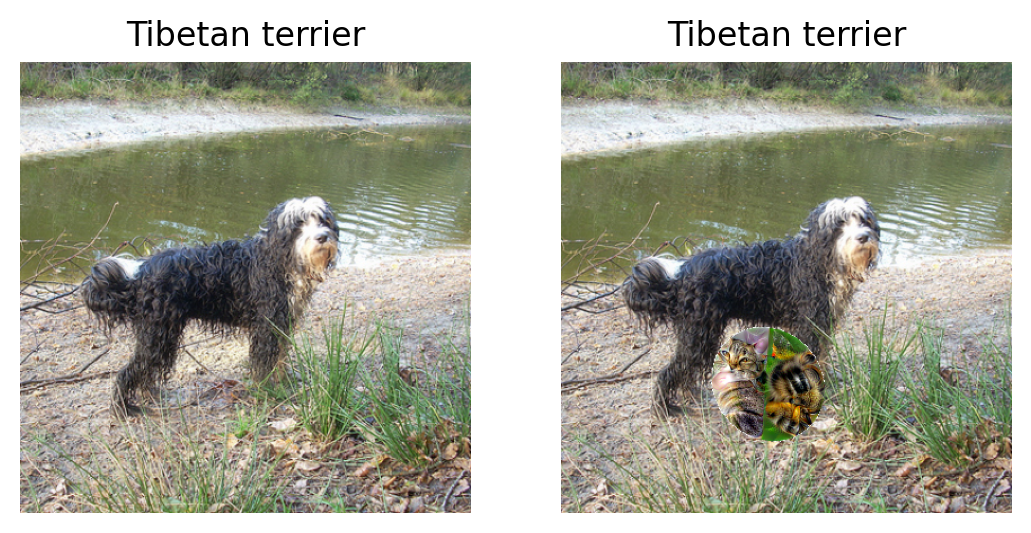

In [97]:
fig, ax = plt.subplots(1,2, squeeze=False, dpi=200)
ax[0,0].axis('off')
ax[0,0].set_title(testset.classes[init_preds.squeeze()[0].item()][0])
ax[0,0].imshow(to_pil(data.cpu().detach().squeeze()))
ax[0,1].axis('off')
ax[0,1].set_title(testset.classes[preds.squeeze()[0].item()][0])
ax[0,1].imshow(to_pil(x.cpu().detach().squeeze()))